# Complete the following notebook.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd gdrive/MyDrive/math398/take_home_2A/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import utils
import time

In [2]:
import  sys
print(sys.executable)


/Users/kevinkasimov/miniconda3/bin/python


In [3]:
#device= torch.device("cuda")
#device= torch.device("cpu")
device = torch.device("mps")
print(device)

mps


In [4]:
print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated


True
True


In [43]:
#torch.cuda.get_device_name()

In [5]:
train_data=torch.load('/Users/kevinkasimov/Documents/Math 540 - Deep Learning/Labs/03-manipulating_data_set/data/cifar/train_data.pt')
train_label=torch.load('/Users/kevinkasimov/Documents/Math 540 - Deep Learning/Labs/03-manipulating_data_set/data/cifar/train_label.pt')
test_data=torch.load('/Users/kevinkasimov/Documents/Math 540 - Deep Learning/Labs/03-manipulating_data_set/data/cifar/test_data.pt')
test_label=torch.load('/Users/kevinkasimov/Documents/Math 540 - Deep Learning/Labs/03-manipulating_data_set/data/cifar/test_label.pt')

print(train_data.size())
print(test_data.size())

torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])


# Implement the network here. Also take care of doing the data augmentation

torch.FloatTensor


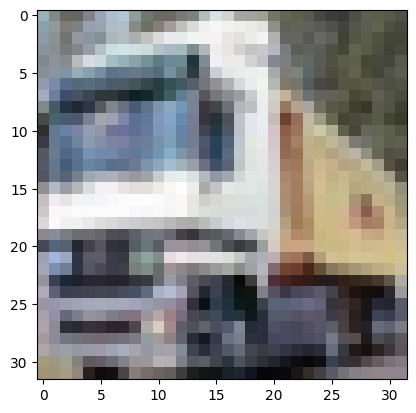

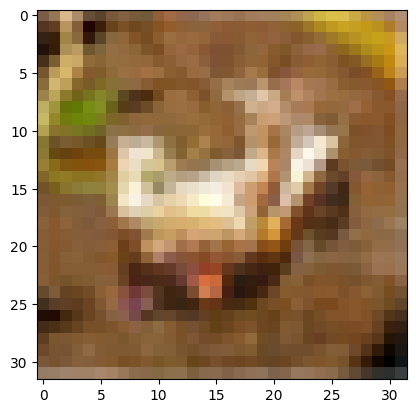

In [6]:
# complete
print(train_data[0].type())
utils.show(train_data[1])
utils.show(torch.flip(train_data[0], [1,2]))

In [7]:
# complete
vflip = torch.flip(train_data, [3]) #data augmentation, flip along vertical axis

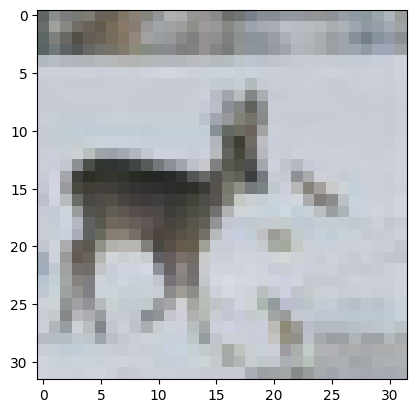

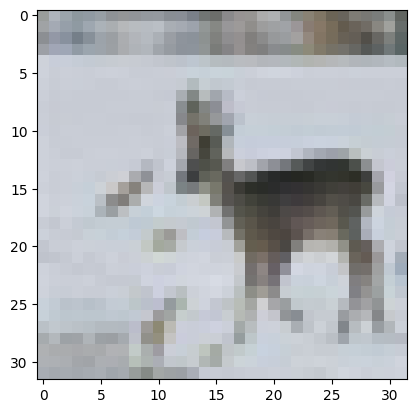

In [8]:
# complete
i = 20
utils.show(vflip[i])
utils.show(train_data[i])

In [9]:
hflip = torch.flip(train_data, [2]) #data augmentation, flip along horizontal axis

In [10]:
# complete
aug_data = torch.cat([train_data, vflip], dim=0)
print(aug_data.size())

torch.Size([100000, 3, 32, 32])


In [11]:
aug_label = torch.cat([train_label, train_label], dim=0)
print(aug_label.size())

torch.Size([100000])


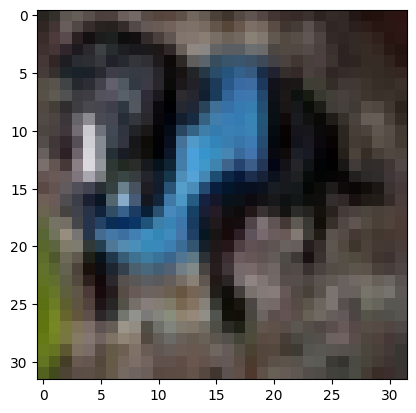

tensor(5)


In [12]:
i = 50027
utils.show(aug_data[i])
print(aug_label[i])

In [13]:
# complete
mean = aug_data.mean()
std = aug_data.std()
print(mean)
print(std)

tensor(0.4734)
tensor(0.2516)


In [14]:
class BasicBlock(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()

        self.conv1 = nn.Conv2d(hidden_size, hidden_size, kernel_size = 3, padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(hidden_size, affine=True)
        self.conv2 = nn.Conv2d(hidden_size, hidden_size, kernel_size = 3, padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(hidden_size, affine=True)

    def forward(self, x):
        #print("forward through basic block")
        #print(x.size(), "before first convolution")
        y = F.relu(self.bn1(self.conv1(x)))
        
        z = F.relu(self.bn2(self.conv2(y)))
        #print(y.size(), "end of basic block")
        return z + x #residual connection



In [15]:
#bridge block has no residual connection
class BridgeBlock(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.conv1 = nn.Conv2d(hidden_size, 2*hidden_size, stride=2, kernel_size = 3, padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(2*hidden_size, affine=True)
        self.conv2 = nn.Conv2d(2*hidden_size, 2*hidden_size, kernel_size = 3, padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(2*hidden_size, affine=True)

    def forward(self, x):
        #print("forward through bridge block")
        #print(x.size(), "before first convolution")
        y = F.relu(self.bn1(self.conv1(x)))
        #print(y.size(), "before second convolution")
        z = F.relu(self.bn2(self.conv2(y)))
        return z

In [55]:
#Full network
'''
X (bs x 3 x 32 x 32) -> Conv -> bn -> Relu
X (bs x 16 x 32 x 32) -> n basic blocks 1
X (bs x 16 x 32 x 32) -> Bridge Block
X (bs x 32 x 16 x 16) -> n basic blocks 2
X (bs x 32 x 16 x 16) -> Bridge Block
X (bs x 64 x 8 x 8) -> n basic blocks 3
X (bs x 64 x 8 x 8) -> Average pooling
X (bs x 64 x 1 x 1) -> Linear
X (bs x 10)
'''

'\nX (bs x 3 x 32 x 32) -> Conv -> bn -> Relu\nX (bs x 16 x 32 x 32) -> n basic blocks 1\nX (bs x 16 x 32 x 32) -> Bridge Block\nX (bs x 32 x 16 x 16) -> n basic blocks 2\nX (bs x 32 x 16 x 16) -> Bridge Block\nX (bs x 64 x 8 x 8) -> n basic blocks 3\nX (bs x 64 x 8 x 8) -> Average pooling\nX (bs x 64 x 1 x 1) -> Linear\nX (bs x 10)\n'

In [16]:
class resnet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.num_layers = num_layers

        #X has size bs x 3 x 32 x 32
        self.conv = nn.Conv2d(input_size,hidden_size,kernel_size = 3, padding=1,bias=False)
        self.bn = nn.BatchNorm2d(hidden_size, affine=True)

        #X has size bs x 16 x 32 x 32

        mylist1 = []
        for i in range(num_layers):
          mylist1.append(BasicBlock(hidden_size))
        self.list_of_mod1 = nn.ModuleList( mylist1 )

        #X has size bs x 16 x 32 x 32

        self.bb1 = BridgeBlock(hidden_size)

        mylist2 = []
        for i in range(num_layers):
          mylist2.append(BasicBlock(2*hidden_size))
        self.list_of_mod2 = nn.ModuleList( mylist2 )

        self.bb2 = BridgeBlock(2*hidden_size)

        mylist3 = []
        for i in range(num_layers):
          mylist3.append(BasicBlock(4*hidden_size))
        self.list_of_mod3 = nn.ModuleList(mylist3)

        #average pooling
        self.avgpool = nn.AvgPool2d(8,8)

        #linear
        self.linear = nn.Linear(4*hidden_size,output_size,bias=True)

    def forward(self, x):
        y = F.relu(self.bn(self.conv(x)))

        for i in range(self.num_layers):
            y = self.list_of_mod1[i](y)

        y = self.bb1(y)

        for i in range(self.num_layers):
            y = self.list_of_mod2[i](y)

        y = self.bb2(y)

        for i in range(self.num_layers):
            y = self.list_of_mod3[i](y)

        y = self.avgpool(y)
        y = y.view(-1,64)
        y = self.linear(y)

        return y


In [17]:
net = resnet(3, 16, 10, 12)
net = net.to(device) #make sure that the weights are the same
mean = mean.to(device)

std = std.to(device)

# Here is the evaluation loop. Please don't change it! Note that the network is called net. Also you need to have defined the variables  "mean" and "std" for this function to work.

In [18]:
def eval_on_test_set():
    net.eval()
    running_error=0
    num_batches=0

    with torch.no_grad():
        for i in range(0,10000,bs):

            minibatch_data =  test_data[i:i+bs]
            minibatch_label= test_label[i:i+bs]

            minibatch_data=minibatch_data.to(device)
            minibatch_label=minibatch_label.to(device)

            inputs = (minibatch_data - mean)/std

            scores = net( inputs )

            error = utils.get_error( scores , minibatch_label)

            running_error += error.item()

            num_batches+=1

    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')

# Implement the training loop below. You must call the function "eval_on_test_set()" at the end of every epoch.

In [19]:
criterion = nn.CrossEntropyLoss()

my_lr = .01

bs= 128

In [20]:
start = time.time()

for epoch in range(1,600):
    
    net.train()
    
    if epoch==200 or epoch == 400:
        my_lr = my_lr / 10
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr, momentum=0.9, weight_decay= 0.0001 )

    running_loss=0
    running_error=0
    num_batches=0

    shuffled_indices=torch.randperm(100000)

    for count in range(0,100000,bs):

        # FORWARD AND BACKWARD PASS

        optimizer.zero_grad()

        indices = shuffled_indices[count:count+bs]
        minibatch_data = aug_data[indices]
        minibatch_label = aug_label[indices]

        minibatch_data = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)

        inputs = (minibatch_data - mean)/std

        inputs.requires_grad_(True)
        #print(inputs.size())
        scores=net( inputs )

        loss = criterion( scores , minibatch_label)

        loss.backward()

        optimizer.step()


        # COMPUTE STATS

        num_batches+=1
        with torch.no_grad():
            running_loss += loss.item()
            error = utils.get_error( scores , minibatch_label)
            running_error += error.item()


    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60

    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_test_set()
    print(' ')



epoch= 1 	 time= 1.2284035841623941 min 	 lr= 0.01 	 loss= 1.6204324578842544 	 error= 59.42195492327366 percent
error rate on test set = 48.526503164556964 percent
 
epoch= 2 	 time= 2.4200246651967365 min 	 lr= 0.01 	 loss= 0.9256789544811639 	 error= 32.74556425831202 percent
error rate on test set = 32.41693037974683 percent
 
epoch= 3 	 time= 3.614663048585256 min 	 lr= 0.01 	 loss= 0.6794015555582997 	 error= 23.371563299232736 percent
error rate on test set = 31.93235759493671 percent
 
epoch= 4 	 time= 4.807117263476054 min 	 lr= 0.01 	 loss= 0.5454292806518047 	 error= 18.8119405370844 percent
error rate on test set = 23.397943037974684 percent
 
epoch= 5 	 time= 5.980088682969411 min 	 lr= 0.01 	 loss= 0.45849224099951325 	 error= 15.8357976342711 percent
error rate on test set = 27.25474683544304 percent
 
epoch= 6 	 time= 7.159929450352987 min 	 lr= 0.01 	 loss= 0.3979204417494557 	 error= 13.799752237851662 percent
error rate on test set = 20.243275316455698 percent
 
epoc

# Select a picture at random and feed it to the network

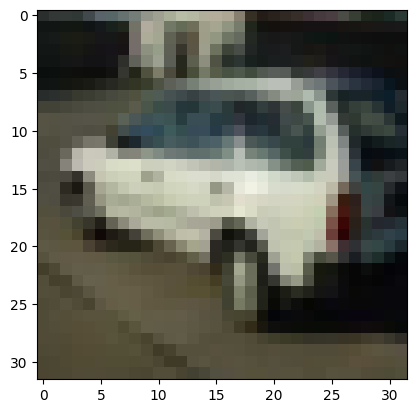

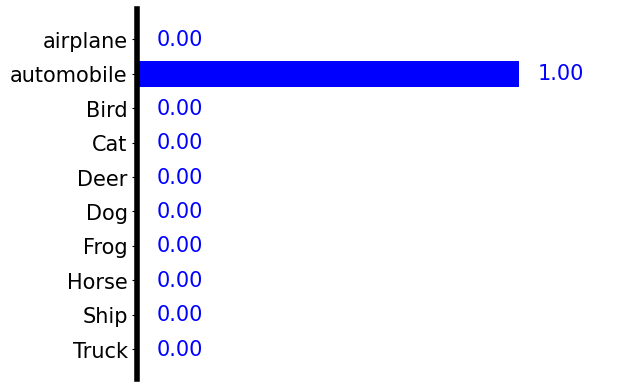

In [52]:
# choose a picture at random
idx=randint(0, 10000-1)
im=test_data[idx]

# diplay the picture
utils.show(im)

# send to device, rescale, and view as a batch of 1
im = im.to(device)
im= (im-mean) / std
im=im.view(1,3,32,32)

# feed it to the net and display the confidence scores
scores =  net(im)
probs= F.softmax(scores, dim=1)
utils.show_prob_cifar(probs.cpu())